In [1]:
import pandas as pd 
import numpy as np 
import torch
from torch import nn
from matplotlib import pyplot as plt 
import seaborn as sbn 
from sklearn import datasets
import time
import utils
import torchvision
import torchvision.transforms as transforms
import os

/home/teddy/miniconda3/envs/bmi543/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


# BMI543/643 Machine Learning 

## Neural Network Tutorial 

In this tutorial we will cover some of the basic of [`pytorch`](https://pytorch.org/) for use developing and training artificial neural networks. 

Pytorch also offers a suite of [tutorials](https://pytorch.org/tutorials/) that may be helpful if you want to learn more. 


# Introduction

Let's begin with a very simple non-linear problem. This will be a `binary classification` problem (e.g., 2 classes), which we will try to solve with a logisitic regression. 


In [2]:
# synthetic data hyperparamaters 
n_samples       = 600
sample_noise    = 0.2
factor          = 0.5

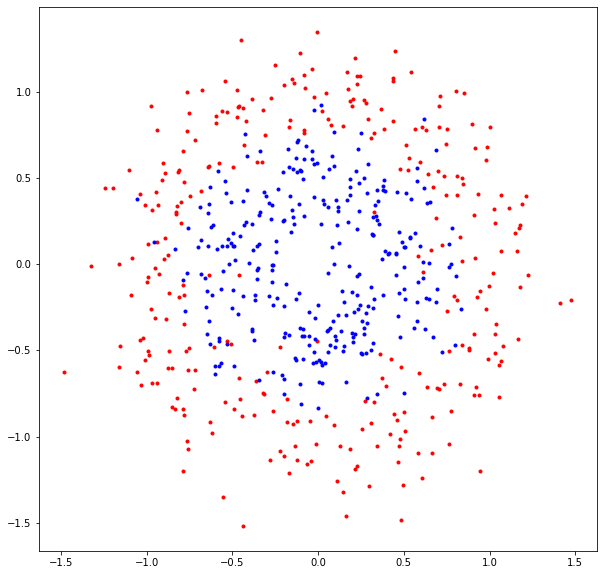

In [3]:

X, y = datasets.make_circles(
    n_samples=n_samples, factor=factor, noise=sample_noise, random_state=0
)
        
red = y==0
blue = y==1

plt.figure(figsize=(10,10))
plt.plot(X[red, 0], X[red, 1], 'r.')
plt.plot(X[blue, 0], X[blue, 1], 'b.')
plt.show()

In [4]:
# make train/test splits | 50/50 split
train_mask = torch.randint(size=y.shape, low=0, high=2) == 1
x_train = torch.tensor(X[train_mask], dtype=torch.float)
y_train = torch.tensor(y[train_mask], dtype=torch.float)

x_test = torch.tensor(X[~train_mask], dtype=torch.float)
y_test = torch.tensor(y[~train_mask], dtype=torch.float)

In [5]:
class Logistic(torch.nn.Module): 
    def __init__(self):
        '''
        initialize our model and paramters
        ''' 
        super().__init__()

        self.lin = torch.nn.Linear(2,1) 

    def forward(self, x): 
        '''
        forward pass 
        '''
        x = self.lin(x)
        x = torch.sigmoid(x)
        return x

In [6]:
# hyperparams ------------------------------------------------
n_epochs = 250 
plot_animation = True                  # this slows the loop down significantly 
anim_every_n_epochs = 15
learning_rate = 1e-2
# -------------------------------------------------------------

# init a model
model = Logistic()

# define our critiria (Binary Cross Entropy)
criteria = torch.nn.BCELoss()

# define our optimizer 
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

# animation 
if plot_animation: myanim = utils.myanimator() 


# training loop 
for epoch in range(n_epochs): 
    print(f'training model... {(epoch+1)/n_epochs*100:.1f}%', end='\r')
    
    # make sure gradients are zero 
    model.zero_grad()
    
    # forward pass 
    yhat = model(x_train)

    # calculate loss of the forward pass 
    loss = criteria(yhat.squeeze(), y_train)

    # calculate parameter specific gradients 
    loss.backward() 

    # update parameter weights 
    optim.step()

    if (plot_animation & (epoch%anim_every_n_epochs==0)): myanim.add_frame(model=model, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, criteria=criteria)

with torch.no_grad():
    print()
    print()
    print(f'train accuracy: {((model(x_train) > 0.5).squeeze() == y_train).float().mean().item():.1f}')
    print(f'test accuracy: {((model(x_test) > 0.5).squeeze() == y_test).float().mean().item():.1f}')
    
tic = time.time() 
gif = None
if plot_animation: gif = myanim.show()
print(f'time for animation: {(time.time() - tic)/60:.2f} min')
gif

training model... 100.0%

train accuracy: 0.6
test accuracy: 0.6

generating animation...
time for animation: 0.23 min


<Figure size 432x288 with 0 Axes>

# Now, let's try a 2-layer neural network

The figure below shows the architecture and labels each layer with the matching names in our `NN.forward()` class method.

This depiction shows a 4 hidden units, which we can change by modifying the `channels` hyperparameter. 

<img src="./figures/2-layer-nn.PNG" alt="drawing" width="500"/>

In [7]:
class NN(torch.nn.Module): 
    def __init__(self, channels):
        '''
        initialize our model and paramters
        ''' 
        super().__init__()

        self.lin1 = torch.nn.Linear(2,channels) 
        self.lin2 = torch.nn.Linear(channels,channels)
        self.out = torch.nn.Linear(channels, 1)
        self.nonlin = torch.nn.ReLU()

    def forward(self, x): 
        '''
        forward pass 
        '''
        h1 = self.lin1(x)
        z1 = self.nonlin(h1)
        h2 = self.lin2(z1)
        z2 = self.nonlin(h2)
        logit = self.out(z2)
        yhat = torch.sigmoid(logit)
        return yhat

In [8]:
# hyperparams ------------------------------------------------
n_epochs                  = 250 
plot_animation            = True                  # this slows the loop down significantly 
anim_every_n_epochs       = 15
learning_rate             = 1e-2
channels                  = 50
# -------------------------------------------------------------

# init a model
model = NN(channels=channels)

# define our critiria (Binary Cross Entropy)
criteria = torch.nn.BCELoss()

# define our optimizer 
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

# animation 
if plot_animation: myanim = utils.myanimator() 


# training loop 
for epoch in range(n_epochs): 
    print(f'training model... {(epoch+1)/n_epochs*100:.1f}%', end='\r')
    
    # make sure gradients are zero 
    model.zero_grad()
    
    # forward pass 
    yhat = model(x_train)

    # calculate loss of the forward pass 
    loss = criteria(yhat.squeeze(), y_train)

    # calculate parameter specific gradients 
    loss.backward() 

    # update parameter weights 
    optim.step()

    if (plot_animation & (epoch%anim_every_n_epochs==0)): myanim.add_frame(model=model, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, criteria=criteria)

with torch.no_grad():
    print()
    print()
    print(f'train accuracy: {((model(x_train) > 0.5).squeeze() == y_train).float().mean().item():.1f}')
    print(f'test accuracy: {((model(x_test) > 0.5).squeeze() == y_test).float().mean().item():.1f}')
    
tic = time.time() 
gif = None
if plot_animation: gif = myanim.show()
print(f'time for animation: {(time.time() - tic)/60:.2f} min')
gif

training model... 100.0%

train accuracy: 0.9
test accuracy: 0.9

generating animation...
time for animation: 0.37 min


<Figure size 432x288 with 0 Axes>

# That looks great, but what's actually happening here? 

`pytorch` uses [autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html), which is automatic differentiation based on the computation graph. We can think of a neural network as a series of nested, differentiable functions: 

$$ \hat{y} = sigmoid(relu(linear(relu(linear(x))))) $$ 

Pytorch automatically builds the computational graph of this when we perform an operation, and stores this to memory, then it uses this computational graph to automatically calculated gradient in our backward pass - e.g., the `loss.backward()` call. 

## As a simple example... 

Let's define the operation: 

$$ d = c*(a^2) $$

where `a=2` and `c=3`, and which we can consider "trainable" parameters. 

The computational graph for the forward operation looks like: 

<img src="./figures/pytorch-comp-graph.PNG" alt="drawing" width="250"/>

In [9]:
a = torch.tensor([1.], requires_grad=True)

b = a ** 2
b.retain_grad() # pytorch only retains gradients in "leaf" nodes, since intermediate nodes don't need to store the values - nothing is being updated! 

c = torch.tensor([3.], requires_grad=True)

d = b*c
d.retain_grad()  

d

tensor([3.], grad_fn=<MulBackward0>)

# We can access the computational graph of each element

In [10]:
for item, name in zip([a,b,c,d], 'abcd'): 
    print('node:', name)
    print('value:', item)
    print('grad_fn:', item.grad_fn)
    if item.grad_fn is not None: print('next grad_fn:', item.grad_fn.next_functions)
    print('is leaf node:', item.is_leaf)
    print('grad:', item.grad)
    print()

node: a
value: tensor([1.], requires_grad=True)
grad_fn: None
is leaf node: True
grad: None

node: b
value: tensor([1.], grad_fn=<PowBackward0>)
grad_fn: <PowBackward0 object at 0x7f8f54785250>
next grad_fn: ((<AccumulateGrad object at 0x7f8f54785070>, 0),)
is leaf node: False
grad: None

node: c
value: tensor([3.], requires_grad=True)
grad_fn: None
is leaf node: True
grad: None

node: d
value: tensor([3.], grad_fn=<MulBackward0>)
grad_fn: <MulBackward0 object at 0x7f8f54785070>
next grad_fn: ((<PowBackward0 object at 0x7f8f54785250>, 0), (<AccumulateGrad object at 0x7f8f54785580>, 0))
is leaf node: False
grad: None



# Every function has a forward operation and a reciprocal backward function. 

For instance, less look at the forward operation of the [`torch.sigmoid()`](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) function 

In [11]:
x = torch.arange(-5,5,0.1, requires_grad=True)
fn = torch.nn.Sigmoid()                             # try with other functions: torch.nn.ReLU(), tanh, etc. 
y = fn(x)                                           # forward operation! 

print('backward function:', y.grad_fn)

backward function: <SigmoidBackward0 object at 0x7f8f54785be0>


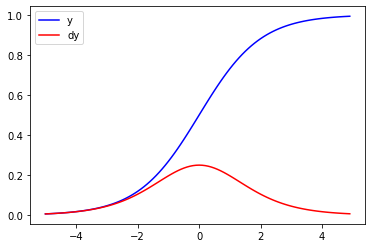

In [12]:
_arbitrary_loss = torch.tensor(1)
dy = y.grad_fn(_arbitrary_loss)

plt.figure()
plt.plot(x.detach(),y.detach(), 'b-', label='y')
plt.plot(x.detach(), dy.detach(), 'r-', label='dy')
plt.legend()
plt.show()

# Back to our previous example... 

Our computational graph has a reciprical backward graph: 

<img src="./figures/autograd_back.PNG" alt="drawing" width="500"/>


## Before we go further, let's take a moment and calculate the gradients by hand: 

Our `forward pass` can be defined as ($l = loss$), let's pretend that `a` is our only trainable parameter for the moment: 

$$ l = (d - ((a^2) * c))^2 $$ 

or, if we break it down into a series of nested function: 

$$ f_4(x) = f_3(f_2(f_1(x))) $$

where, 

$ b = f_1(x) = x^2 $   
$ \hat{d} = f_2(x) = c*x $   
$ l = f_3(x) = (d - x)^2$   

and therefore, our `backward pass` can be derived via the [chain rule](https://en.wikipedia.org/wiki/Chain_rule):

$$ \frac{dl}{da} = \frac{dl}{dd} * \frac{dd}{db} * \frac{db}{da} $$ 

or put a different way: 

$$ f'_4(x) = f'_3(f_2(f_1(x))) * f'_2(f_1(x)) * f'_1(x) $$

Using these equations, and the values: 

`a = 1`   
`c = 3`  
`d = 2` (target)   

### Calculate the gradient for `a`:

1. $ \frac{dl}{dd} = ? $  

2. $ \frac{d\hat{d}}{db} = ? $  

3. $ \frac{db}{da} = ? $  

and then combining (1-3): 

$ \frac{dl}{da} = ? $


### Calculate the gradient for `b`:


$ \frac{dl}{db} = ? $


### Calculate the gradient for `c`:

$ \frac{dl}{dc} = ? $


# Now, let's compare to the autograd results 

In [13]:
a = torch.tensor([1.], requires_grad=True)

b = a ** 2
b.retain_grad()

c = torch.tensor([3.], requires_grad=True)

dhat = b*c
dhat.retain_grad()

d = torch.tensor([2], requires_grad=False) # target! 

loss = (dhat-d)**2

loss.backward()  # our backward pass 

In [14]:
for item,name in zip([a,b,c,d], ['a','b','c','d']): 
    print('name:', name)
    print('gradient:', item.grad)
    print()

name: a
gradient: tensor([12.])

name: b
gradient: tensor([6.])

name: c
gradient: tensor([2.])

name: d
gradient: None



# `backward()` by hand... 

To understand what the `tensor.backward()` function is doing, let's try to calculate the gradient of `a` by using the `grad_fn` and `next_functions()`. 

<img src="./figures/autograd_back.PNG" alt="drawing" width="500"/>

In [15]:
a = torch.tensor([1.], requires_grad=True)

b = a ** 2
b.retain_grad()

c = torch.tensor([3.], requires_grad=True)

dhat = b*c
dhat.retain_grad()

d = torch.tensor([2], requires_grad=False) # target! 

loss = (dhat-d)**2


# access each of the backward functions individually - 
back_loss_pow = loss.grad_fn
back_loss_sub = back_loss_pow.next_functions[0][0]
back_mult = back_loss_sub.next_functions[0][0]
# NOTE! back_mult.next_functions has TWO functions; why do you think? which do we care about? 
back_pow = back_mult.next_functions[0][0]

da = back_pow(back_mult(back_loss_sub(back_loss_pow(loss))[0])[0]) 
da

tensor([12.], grad_fn=<MulBackward0>)

# We can calculate gradients, but how do we update the parameter weights? 

In [16]:
# let's only optimize a so that our function predicts the target d=2
a = torch.tensor([1.], requires_grad=True)

# initialize and optimizer and pass the trainable parameters to it. 
# stochastic gradient descent 
optim = torch.optim.SGD([a], lr=1e-2)

# calculate our loss: 
b = a ** 2
b.retain_grad()
c = torch.tensor([3.], requires_grad=True)
dhat = b*c
dhat.retain_grad()
d = torch.tensor([2], requires_grad=False) # target! 
loss = (dhat-d)**2

# calculate the gradients for each parameter 
loss.backward() 

# let the optimizer modify our parameters (a) in the direction specified by gradients
optim.step()

## Before running the next cell, do you think `a` will be greater or less than it's previous value (1)? 

Remember, the gradient calculated was `12` 

Why? 

In [17]:
a

tensor([0.8800], requires_grad=True)

# run a number of iterations

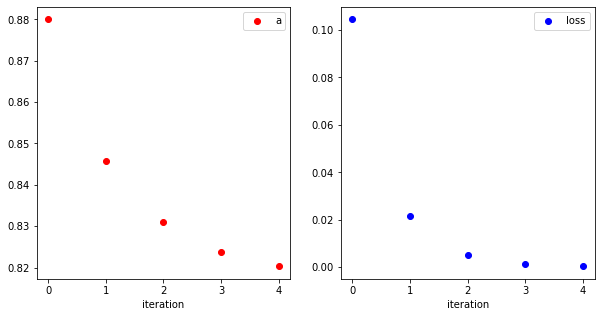

In [18]:
_a = []
_l = [] 

for i in range(5): 
    _a.append(a.detach().item())
    # this resets all parameters gradients to zero (otherwise they accumulate)
    optim.zero_grad()
    
    # calculate our loss: 
    b = a ** 2
    b.retain_grad()
    c = torch.tensor([3.], requires_grad=True)
    dhat = b*c
    dhat.retain_grad()
    d = torch.tensor([2], requires_grad=False) # target! 
    loss = (dhat-d)**2
    _l.append(loss.detach().item())
    # calculate the gradients for each parameter 
    loss.backward() 

    # let the optimizer modify our parameters (a) in the direction specified by gradients
    optim.step()
    
f,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(_a, 'ro', label='a')
axes[1].plot(_l, 'bo', label='loss')
axes[0].legend(); axes[1].legend()
axes[0].set_xlabel('iteration'); axes[1].set_xlabel('iteration')
plt.show()

# Excercise: Fix `a=4` and optimize c such that `d=2`

Initialize `c=10`

final c: tensor([0.1326], requires_grad=True)


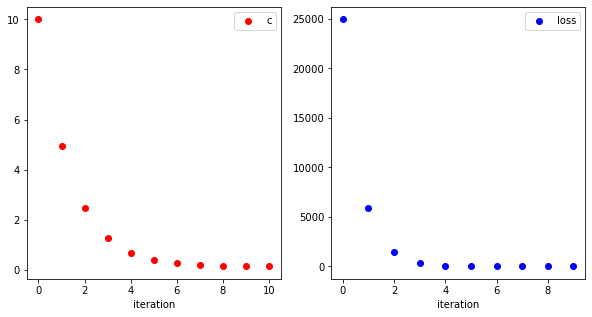

In [19]:
# sol-n: 

a = torch.tensor([4.], requires_grad=False)
c = torch.tensor([10.], requires_grad=True)
d = torch.tensor([2.], requires_grad=False)

def mymodel(a,c,d): 
    b = a ** 2
    dhat = b*c
    loss = (dhat-d)**2
    return loss 

optim = torch.optim.SGD([c], lr=1e-3)

_c = [c.detach().item()] 
_l = []
for i in range(10): 
    optim.zero_grad()
    
    loss = mymodel(a,c,d)
    
    loss.backward() 

    optim.step()
    
    _c.append(c.detach().item())
    _l.append(loss.detach().item())

print('final c:', c)
f,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(_c, 'ro', label='c')
axes[1].plot(_l, 'bo', label='loss')
axes[0].legend(); axes[1].legend()
axes[0].set_xlabel('iteration'); axes[1].set_xlabel('iteration')
plt.show()

# What about our choice of `optimizer`? 

Why are there so many optimizers? how do we choose? Is there any difference? 

[optimizer visual comparisons](https://github.com/Jaewan-Yun/optimizer-visualization)

[Descending through a Crowded Valley — Benchmarking Deep Learning Optimizers](https://arxiv.org/pdf/2007.01547.pdf)

Some fairly safe choices: 

1. [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
2. [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)
3. [RMSProp](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)

training model with optimizer: rmsprop, replicate 2	
training model with optimizer: rmsprop, replicate 2	
training model with optimizer: rmsprop, replicate 2	


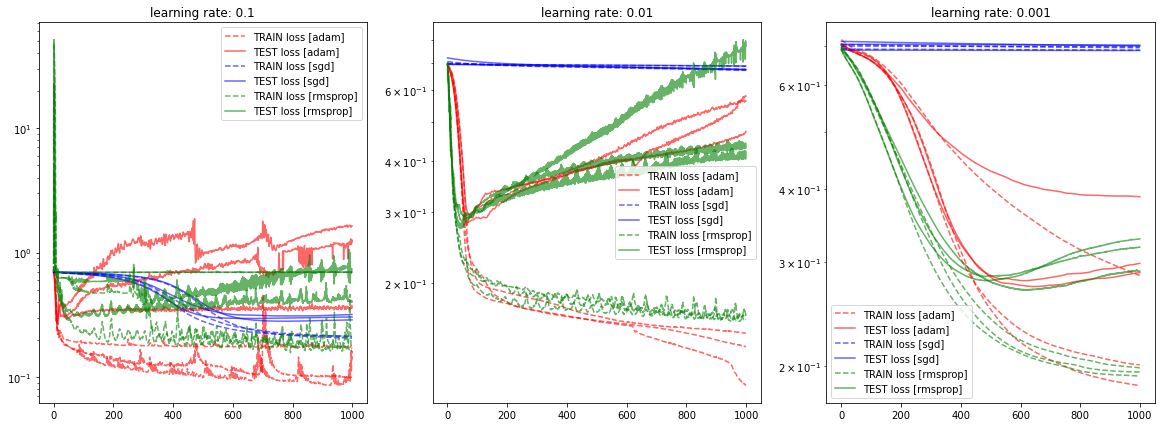

In [20]:
f, axes = plt.subplots(1,3, figsize=(20, 7))

for lr,ax in zip([1e-1, 1e-2, 1e-3], axes.flat):
    for optim,name,c in zip([torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop], ['adam','sgd','rmsprop'], ['r','b','g']): 
        for i in range(3): 

            print(f'training model with optimizer: {name}, replicate {i}\t', end='\r')
            model, trn, tst = utils.train_model(x_train, 
                                                y_train, 
                                                x_test, 
                                                y_test, 
                                                optim=optim, 
                                                n_epochs=1000, 
                                                learning_rate=lr, 
                                                channels=10, 
                                                verbose=False)

            alpha=0.6
            if i == 0: 
                ax.plot(trn, f'{c}--', label=f'TRAIN loss [{name}]', alpha=alpha)
                ax.plot(tst, f'{c}-', label=f'TEST loss [{name}]', alpha=alpha)
            else:
                ax.plot(trn, f'{c}--', alpha=alpha)
                ax.plot(tst, f'{c}-', alpha=alpha)    
    print()
    ax.set_yscale('log')
    ax.legend()
    ax.set_title(f'learning rate: {lr}')

plt.show()

# Hands on - classify breast cancer 

[dataset information](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset) 

Dataset References

W.N. Street, W.H. Wolberg and O.L. Mangasarian. Nuclear feature extraction for breast tumor diagnosis. IS&T/SPIE 1993 International Symposium on Electronic Imaging: Science and Technology, volume 1905, pages 861-870, San Jose, CA, 1993.

O.L. Mangasarian, W.N. Street and W.H. Wolberg. Breast cancer diagnosis and prognosis via linear programming. Operations Research, 43(4), pages 570-577, July-August 1995.

W.H. Wolberg, W.N. Street, and O.L. Mangasarian. Machine learning techniques to diagnose breast cancer from fine-needle aspirates. Cancer Letters 77 (1994) 163-171.

# Batch normalization 

Sergey Ioffe and Christian Szegedy. 2015. [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167) . In Proceedings of the 32nd International Conference on International Conference on Machine Learning - Volume 37 (ICML'15). JMLR.org, 448–456.

<img src="./figures/bn_alg1.PNG" alt="drawing" width="300"/>

<img src="./figures/bn_fig1.PNG" alt="drawing" width="300"/>

[batch norm 1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) 


# Dropout 

Nitish Srivastava, Geoffrey Hinton, Alex Krizhevsky, Ilya Sutskever, and Ruslan Salakhutdinov. 2014. [Dropout: a simple way to prevent neural networks from overfitting](https://dl.acm.org/doi/10.5555/2627435.2670313). J. Mach. Learn. Res. 15, 1 (January 2014), 1929–1958. 


<img src="./figures/do_fig1.PNG" alt="drawing" width="300"/>


[dropout docs](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)


In [23]:
X,y = datasets.load_breast_cancer(return_X_y=True)

print('# observations, # features)', X.shape)
print('class balance:', y.mean())

df = pd.DataFrame(X).assign(y=y)

# create train/test/val split
np.random.seed(0)
train, val, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
print('train', train.shape)
print('val', val.shape)
print('test', test.shape)

# observations, # features) (569, 30)
class balance: 0.6274165202108963
train (341, 31)
val (114, 31)
test (114, 31)


In [24]:
x_train = torch.tensor(train[train.columns[:-1]].values, dtype=torch.float)
y_train = torch.tensor(train[train.columns[-1]].values, dtype=torch.long)

x_test = torch.tensor(test[test.columns[:-1]].values, dtype=torch.float)
y_test = torch.tensor(test[test.columns[-1]].values, dtype=torch.long)

x_val = torch.tensor(val[val.columns[:-1]].values, dtype=torch.float)
y_val = torch.tensor(val[val.columns[-1]].values, dtype=torch.long)

In [ ]:
# useful functions: 

# torch.nn.Linear() 
# torch.nn.ReLU() 

In [25]:
class NN(torch.nn.Module): 
    def __init__(self):
        '''
        initialize our model and paramters
        ''' 
        super().__init__()
        # how many layers will you include? 
        # how many channels? 
        # what kind of nonlinearity ?
        
        # def first linear layer 
        self.lin1 = # your code
        
        # def second linear layer 
        self.lin2 = 
        
        # def third linear layer 
        # ... 
        
        # ... 
        
        # def output layer 
        ### NOTE: we're going to use the CROSS ENTROPY loss function, so we need the same 
        ###       number of outputs as we have classes (2)

        
        # def nonlinear activation function 
    
    def forward(self, x): 
        '''
        forward pass 
        '''
        
        # linear layer 
        h1 = self.lin(x) 
        
        # activation 
        z1 = # your code 
        
        # linear layer 
        
        # activation 
        
        # ... 
        
        # output layer 
        logits = # your code 
        
        return softmax(logits, dim=-1)

In [ ]:
# useful functions

# torch.module.zero_grad() 
# torch.tensor.backwards() 

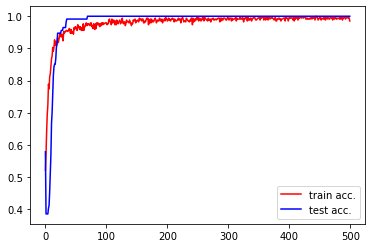

In [26]:
# hyperparams ------------------------------------------------
n_epochs                  = 500 
learning_rate             = 1e-3
weight_decay              = 0.
# -------------------------------------------------------------

# init a model
model = NN() # add any inputs you need here. 

# define our critiria (Binary Cross Entropy)
# NOTE: we use class weights to balance the classes 
class_weight = y_train.float().mean()
criteria = torch.nn.CrossEntropyLoss(weight=torch.tensor([class_weight, 1-class_weight]))

# define our optimizer 
optim = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# training loop 
train_acc = []
test_acc = []
for epoch in range(n_epochs): 
    print(f'training model... {(epoch+1)/n_epochs*100:.1f}%', end='\r')
    
    # make sure gradients are zero 
    
    
    # forward pass 
    yhat = ... 

    # calculate loss of the forward pass 
    loss = ... 

    # calculate parameter specific gradients 

    
    # update parameter weights 

    
    
    train_acc.append(((yhat.argmax(dim=-1)) == y_train).float().mean().detach().item())
    model.eval()
    test_acc.append(((model(x_test).detach().argmax(dim=-1)) == y_test).float().mean().item())
    model.train()
        
plt.figure()
plt.plot(train_acc, 'r-', label='train acc.')
plt.plot(test_acc, 'b-', label='test acc.')
plt.legend()
plt.show()

In [27]:
model.eval()
val_acc = ((model(x_val).detach().argmax(dim=-1)) == y_val).float().mean().item()
print('final validation accuracy:', val_acc)

final validation accuracy: 0.9473684430122375


# Convolutional Neural Networks 

This CNN walk-through has code originally developed in the [this](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) pytorch tutorial. 


See [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) for a tutorial on the use and inner-workings of pytorch dataloaders and datasets. 

In [28]:
# download the CIFAR10 dataset : https://www.cs.toronto.edu/~kriz/cifar.html
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10('./data/', download=True, train=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10('./data/', download=False, train=False, transform=transform)

Files already downloaded and verified


In [29]:
batch_size = 4

if not os.path.exists('./data/'): 
    os.mkdir('./data/')


trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=5)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

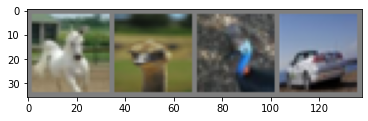

horse bird  bird  car  


In [30]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [31]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # in channels, out channels, kernel size 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        self.nonlin = torch.nn.ReLU()

    def forward(self, x):
        x = self.pool(self.nonlin(self.conv1(x)))
        x = self.pool(self.nonlin(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.nonlin(self.fc1(x))
        x = self.nonlin(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [33]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}', end='\r')
            running_loss = 0.0
print()
print('Finished Training')

[5, 12000] loss: 1.058
Finished Training


# While our model is training, GPUs! 

One way to speed up model training is by using a graphical processing unit (GPU) or a tensor processing unit (TPU).

Understand the difference between GPU and central processing unit (CPU) [here](https://www.heavy.ai/technical-glossary/cpu-vs-gpu). 

Must have a cuda enabled GPU (nvidia card) to use with pytorch. A few useful tutorials: 

- [How To Use GPU with PyTorch](https://wandb.ai/wandb/common-ml-errors/reports/How-To-Use-GPU-with-PyTorch---VmlldzozMzAxMDk)
- [Use GPU in your PyTorch code](https://medium.com/ai%C2%B3-theory-practice-business/use-gpu-in-your-pytorch-code-676a67faed09)
- [PyTorch: Switching to the GPU](https://towardsdatascience.com/pytorch-switching-to-the-gpu-a7c0b21e8a99) 

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [ ]:
# assuming equal classes - what would we expect a random predictors accuracy to be? 
# num classes? 

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

# What is actually happening here? 

Let's start by choosing an image, change the `img_index` value to find one you like. 

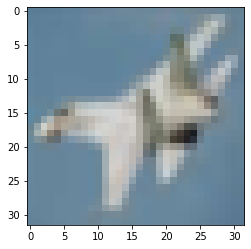

image shape: torch.Size([3, 32, 32])
class label: plane

predicted probabilities:
	plane	: 0.47
	car	: 0.02
	bird	: 0.24
	cat	: 0.01
	deer	: 0.07
	dog	: 0.00
	frog	: 0.02
	horse	: 0.00
	ship	: 0.15
	truck	: 0.01


In [103]:
# pick an image
img_index = 10

img, label = test_dataset.__getitem__(img_index)
imshow(img)
print('image shape:', img.shape)
print('class label:', classes[label])

pred=torch.softmax(net(img.unsqueeze(0)), dim=-1)
print()
print('predicted probabilities:')
for i, c in enumerate(classes): 
    print(f'\t{c}\t: {pred[0, i]:.2f}')
    


# Let's visualize what the first convolutional layer is doing

In [104]:
# access the kernel 
conv1 = net.conv1.weight.data.detach()
conv1.shape # (out channels, in channels, kernel width, kernel height)

torch.Size([6, 3, 5, 5])

In [105]:
# convolve our image (activation of layer 1)
conv1_img = net.conv1(img.unsqueeze(0)).squeeze(0)
conv1_img.shape

torch.Size([6, 28, 28])

In [106]:
# we can access one channel of the linear transformation, e.g., the convolved image
conv1_img[0,:,:].unsqueeze(0).shape

torch.Size([1, 28, 28])

In [107]:
# max pooling reduces the image size (28 / 2)
net.pool(conv1_img[0,:,:].unsqueeze(0)).shape

torch.Size([1, 14, 14])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


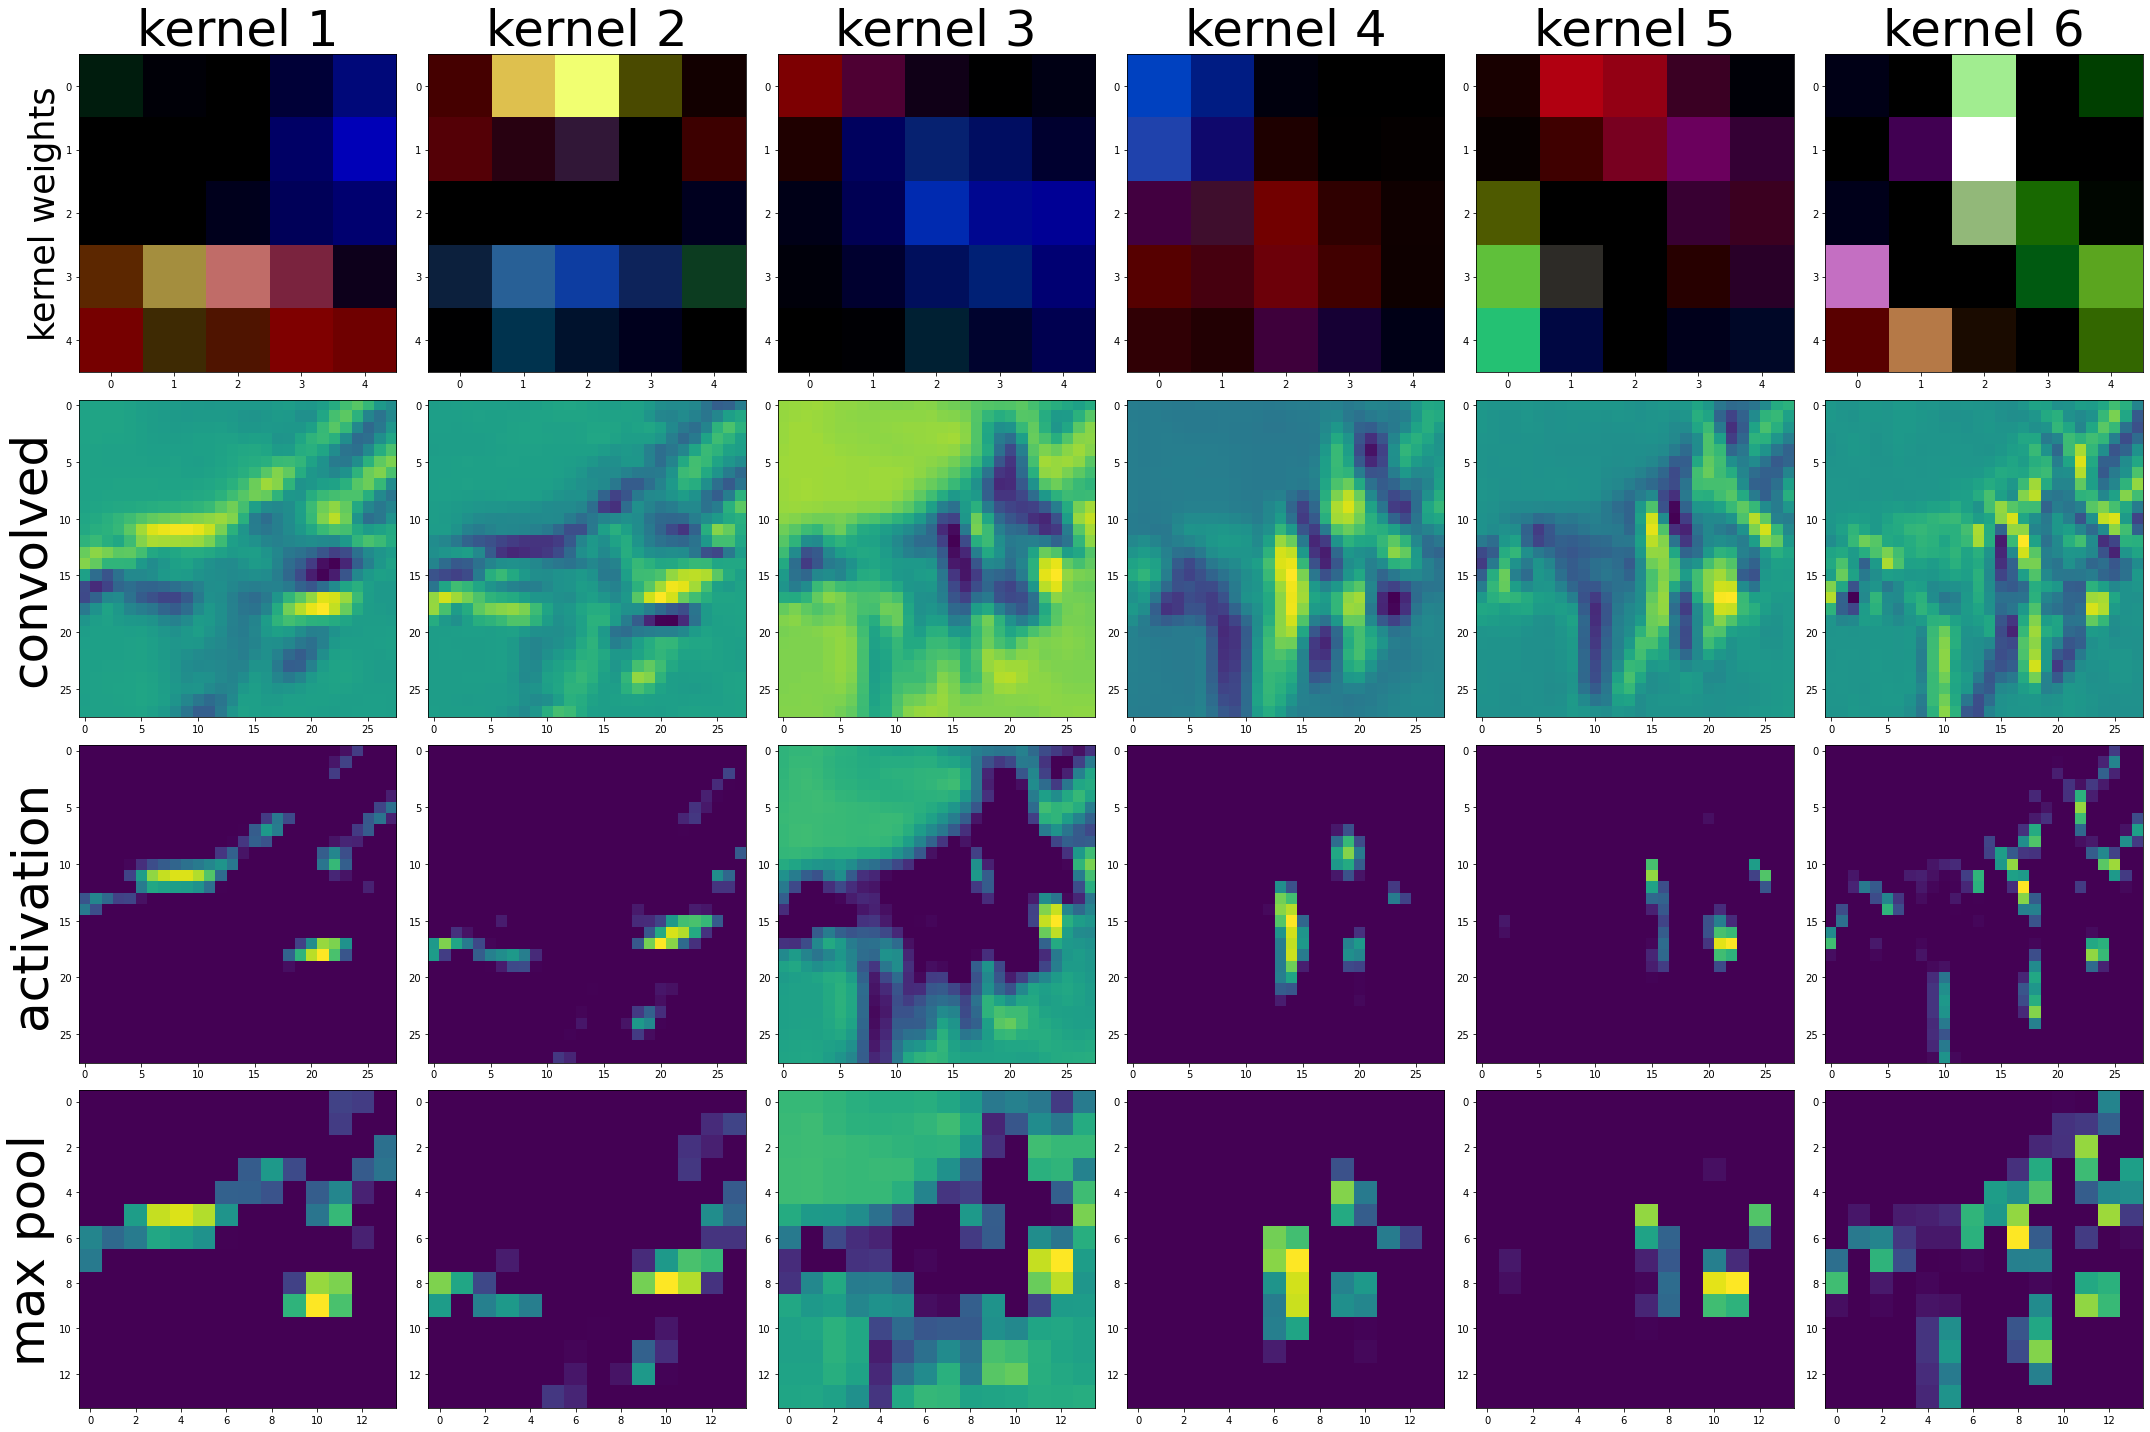

In [120]:
n_filters = 6

f, axes = plt.subplots(4,n_filters,figsize=(n_filters*5, 20))

for i in range(n_filters):
    utils.imshow2(conv1[i,:,:,:], axes[0, i], unnorm=False) 
    utils.imshow2(conv1_img[i,:,:].unsqueeze(0), axes[1, i], unnorm=True)
    utils.imshow2(net.nonlin(conv1_img[i,:,:].unsqueeze(0)), axes[2, i], unnorm=True)
    utils.imshow2(net.pool(net.nonlin(conv1_img[i,:,:].unsqueeze(0))), axes[3, i],unnorm=True)

    
axes[0,0].set_ylabel('kernel weights', fontsize=35)
axes[1,0].set_ylabel('convolved', fontsize=50)
axes[2,0].set_ylabel('activation', fontsize=50)
axes[3,0].set_ylabel('max pool', fontsize=50)

for i in range(n_filters): 
    axes[0,i].set_title(f'kernel {i+1}', fontsize=50)
    
plt.tight_layout()
plt.show()

# Excercise: try to manually create a kernel 

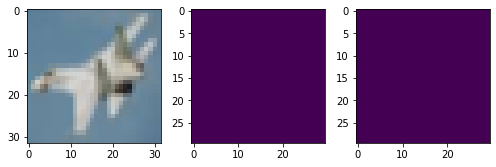

In [211]:
# MODIFY THIS VVVV

# pick an image
img_index = 10

myconv = torch.nn.Conv2d(3,1,3) # 3x3 kernel 

myconv.weight.data = torch.tensor([[[0,0,0],         # RED color channel 
                                    [0,0,0],
                                    [0,0,0]], 
                                   
                                   [[0,0,0],         # BLUE color channel
                                    [0,0,0],
                                    [0,0,0]],
                                   
                                   [[0,0,0],         # GREEN color channel
                                    [0,0,0],
                                    [0,0,0]]], dtype=torch.float).unsqueeze(0)

# ^^^^^^^^^^^^^^^

img, label = test_dataset.__getitem__(img_index)
convolved_img = myconv(img.unsqueeze(0)).squeeze(0).detach()

f,axes=plt.subplots(1,3,figsize=(7,21))
utils.imshow2(img, axes[0], unnorm=True)
utils.imshow2(convolved_img, axes[1])
utils.imshow2(torch.nn.functional.relu(convolved_img), axes[2])
plt.tight_layout()
plt.show()

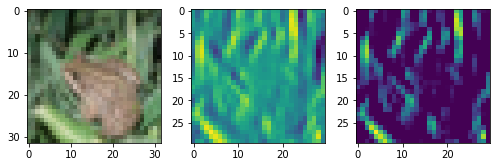

In [212]:
# example: Vertical LINE

# pick an image
img_index = 4

myconv = torch.nn.Conv2d(3,1,3) # 3x3 kernel 

myconv.weight.data = torch.tensor([[[-1,0,1],         # RED color channel 
                                    [-1,0,1],
                                    [-1,0,1]], 
                                   
                                   [[-1,0,1],         # RED color channel 
                                    [-1,0,1],
                                    [-1,0,1]],
                                   
                                   [[-1,0,1],         # RED color channel 
                                    [-1,0,1],
                                    [-1,0,1]]], dtype=torch.float).unsqueeze(0)

# ^^^^^^^^^^^^^^^

img, label = test_dataset.__getitem__(img_index)
convolved_img = myconv(img.unsqueeze(0)).squeeze(0).detach()

f,axes=plt.subplots(1,3,figsize=(7,21))
utils.imshow2(img, axes[0], unnorm=True)
utils.imshow2(convolved_img, axes[1])
utils.imshow2(torch.nn.functional.relu(convolved_img), axes[2])
plt.tight_layout()
plt.show()